In [8]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '11c_HhAyF2hqrOcdtTnwB0G90vqIsyuUz'
downloaded = drive.CreateFile({'id': file_id})

downloaded.GetContentFile('RUL_training-data.xlsx')

!pip install -q xlrd

import pandas as pd
df = pd.read_excel('RUL_training-data.xlsx')

# we import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from sklearn import metrics

x_input = df.to_numpy()

#------------------------------------------------

time = []
#time array is the collection of life of all engine times 
indice = []

for i in range(0, x_input.shape[0]-1):
  if x_input[i][0] != x_input[i+1][0]:
    time.append(x_input[i][1])
    indice.append(i)
  else:
    continue

time.append(x_input[x_input.shape[0]-1][1])
indice.append(x_input.shape[0]-1)

time = np.array(time)
indice = np.array(indice)

#time.shape should give number of engines i.e. 133

#-------------------------------------------------
y_train = []

#array y gives RUL - Remaining Useful Life corresponding to each row in x

j = 0
for i in range(0, x_input.shape[0]):
  y_train.append(time[j] - x_input[i][1])
  if time[j] == x_input[i][1]:
    j = j+1

y_train = np.array(y_train)

#----------------------------------------------
x_train = np.delete(x_input, 0, 1)

#----------------------------------------------
file_id = '1l_jOjgrQNVipZsRgSTHd0Qf81oloHmTX'
downloaded = drive.CreateFile({'id': file_id})

downloaded.GetContentFile('RUL_testing-data.xlsx')

df2 = pd.read_excel('RUL_testing-data.xlsx')
x_input2 = df2.to_numpy()
#----------------------------------------------

time2 = []
indice2 = []

for i in range(0, x_input2.shape[0]-1):
  if x_input2[i][0] != x_input2[i+1][0]:
    time2.append(x_input2[i][1])
    indice2.append(i)
  else:
    continue

time2.append(x_input2[x_input2.shape[0]-1][1])
indice2.append(x_input2.shape[0]-1)

time2 = np.array(time2)
indice2 = np.array(indice2)

#-------------------------------------------
y_test = []

#array y gives RUL - Remaining Useful Life corresponding to each row in x

j = 0
for i in range(0, x_input2.shape[0]):
  y_test.append(time2[j] - x_input2[i][1])
  if time2[j] == x_input2[i][1]:
    j = j+1

y_test = np.array(y_test)

#-----------------------------------------

x_test = np.delete(x_input2, 0, 1)
#----------------------------------------

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(x_train[1:])
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

#---------------------------------------

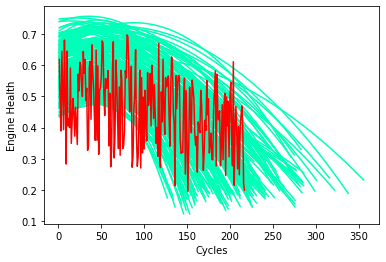

In [9]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(218)

#----------------------------------------
k = 0
y_target = np.zeros([x_input.shape[0] ,1])
for i in range(0, x_input.shape[0]):
  y_target[i] = 1 - (x_input[i][1] / time[k])
  if time[k] == x_input[i][1]:
    k = k+1

#ad_mat = np.ones([x_input.shape[0] ,1])
feature_mat = np.zeros([x_input.shape[0] ,3])

for i in range(0, x_input.shape[0]):
  #s16 column 21
  #feature_mat[i][0] = x_input[i][20]
  #s11 column 16
  feature_mat[i][0] = x_input[i][15]
  #s2 column 7
  feature_mat[i][1] = x_input[i][6]
  #s15 column 20
  feature_mat[i][2] = x_input[i][19]


#weights = np.dot(np.dot(np.linalg.inv(np.dot(feature_mat.T, feature_mat)), feature_mat.T), y_target)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(feature_mat, y_target)
weights = reg.coef_

weights = weights.T

engine_health = np.zeros([x_input.shape[0], 1])

for i in range(0, x_input.shape[0]):
  engine_health[i][0] = (weights[0]*x_input[i][15]) + (weights[1]*x_input[i][6]) + (weights[2]*x_input[i][19]) + reg.intercept_


#output matrix tyaar for linear reg
#----------------------------------------

engine_health_train = np.zeros([x_input.shape[0], 1])
#engine_health_train quadratic best fit curves hai

for k in range(0, 217):
  if k==0:
    cc = np.polyfit(x_input[0:indice[0], 1], engine_health[0:indice[0], 0], 2)
    engine_health_train[0:indice[0], 0] = cc[0]*x_input[0:indice[0], 1]**2 + cc[1]*x_input[0:indice[0], 1] + cc[2]
  cc = np.polyfit(x_input[indice[k]+1:indice[k+1], 1], engine_health[indice[k]+1:indice[k+1], 0], 2)
  engine_health_train[indice[k]+1:indice[k+1], 0] = cc[0]*x_input[indice[k]+1:indice[k+1], 1]**2 + cc[1]*x_input[indice[k]+1:indice[k+1], 1] + cc[2]

#engine_health_train best fit curves ka matrix hai
#----------------------------------------------------------

#testing data ka engine_health_test matrix:
engine_health_test = np.zeros([x_input2.shape[0], 1])

for i in range(0, x_input2.shape[0]):
  engine_health_test[i][0] = (weights[0]*x_input2[i][15]) + (weights[1]*x_input2[i][6]) + (weights[2]*x_input2[i][19]) + reg.intercept_

#----------------------------------------------------------

for k in range(0, 217):
  if k==0:
    plt.plot(x_input[0:indice[0], 1], engine_health_train[0:indice[0] ,0], c=cmap(100))
  plt.plot(x_input[indice[k]+1:indice[k+1], 1], engine_health_train[indice[k]+1:indice[k+1] ,0], c=cmap(100))

plt.xlabel("Cycles")
plt.ylabel("Engine Health")

plt.plot(x_input2[indice2[3]+1:indice2[4], 1], engine_health_test[indice2[3]+1:indice2[4], 0], c=cmap(0))

In [10]:
start = indice2[3]+1
end = indice2[4]
#the above values are for 5th engine in test data
all_cycles = []

for j in range(start+1, end):
  avg_dist = []
  dist = []

  for k in range(0, 217):
    if k==0:
      dist = []
      for i in range(0, j-start):
        d  = np.sqrt(np.power(engine_health_train[i, 0] - engine_health_test[i+start, 0] ,2 ))
        dist.append(d)
      avg_dist.append(np.mean(dist))
    dist = []
    for i in range(indice[k]+1, indice[k]+1 + j-start):
      if(i>=45918):
        continue
      d  = np.sqrt(np.power(engine_health_train[i, 0] - engine_health_test[i+start - (indice[k]+1), 0] ,2 ))
      dist.append(d)
    avg_dist.append(np.mean(dist))

  avg_dist = np.array(avg_dist)
  #-----------------------------
  temp_arr = np.zeros([218, 1])

  for i in range(0, 218):
    temp_arr[i] = avg_dist[i]

  temp_arr.sort(axis=0)

  engine_number = []
  for i in range(0, 10):
    ak = np.where(avg_dist == temp_arr[i])
    ak = np.array(ak)
    engine_number.append(np.asscalar(ak))

  engine_number = np.array(engine_number)

  final_rul = []
  for i in range(0, 10):
    final_rul.append(time[engine_number[i]])

  final_rul = np.array(final_rul)
  ans = np.median(final_rul)
  print("time =", j-start, "cycles ","predicted life = ",ans,"cycles ", " ","original life = ", x_input2[indice2[4], 1],"cycles ")
  all_cycles.append(ans)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


time = 1 cycles  predicted life =  208.5 cycles    original life =  218.0 cycles 
time = 2 cycles  predicted life =  199.5 cycles    original life =  218.0 cycles 
time = 3 cycles  predicted life =  226.0 cycles    original life =  218.0 cycles 
time = 4 cycles  predicted life =  278.0 cycles    original life =  218.0 cycles 
time = 5 cycles  predicted life =  216.5 cycles    original life =  218.0 cycles 
time = 6 cycles  predicted life =  222.0 cycles    original life =  218.0 cycles 
time = 7 cycles  predicted life =  216.5 cycles    original life =  218.0 cycles 
time = 8 cycles  predicted life =  228.0 cycles    original life =  218.0 cycles 
time = 9 cycles  predicted life =  189.5 cycles    original life =  218.0 cycles 
time = 10 cycles  predicted life =  252.5 cycles    original life =  218.0 cycles 
time = 11 cycles  predicted life =  177.5 cycles    original life =  218.0 cycles 
time = 12 cycles  predicted life =  209.0 cycles    original life =  218.0 cycles 
time = 13 cyc

In [11]:
all_cycles = np.array(all_cycles)
print(np.mean(all_cycles))

223.11342592592592


Text(0, 0.5, 'Final Engine Life: original vs predicted')

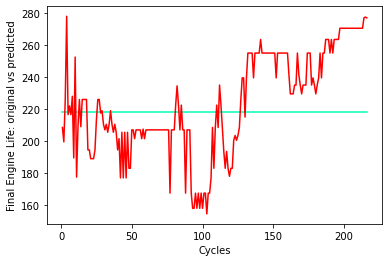

In [12]:
x_ax = np.linspace(1, 216, 216)
y_ax = np.linspace(218, 218, 216)
plt.plot(x_ax, y_ax, c = cmap(100))
plt.plot(x_ax, all_cycles, c = cmap(0))
plt.xlabel("Cycles")
plt.ylabel("Final Engine Life: original vs predicted")

In [23]:
mean_ans_array = []
for itr in range(0, 217):
  
  start = indice2[itr]+1
  end = indice2[itr+1]

  all_cycles = []

  for j in range(start+1, end):
    avg_dist = []
    dist = []

    for k in range(0, 217):
      if k==0:
        dist = []
        for i in range(0, j-start):
          d  = np.sqrt(np.power(engine_health_train[i, 0] - engine_health_test[i+start, 0] ,2 ))
          dist.append(d)
        avg_dist.append(np.mean(dist))
      dist = []
      for i in range(indice[k]+1, indice[k]+1 + j-start):
        if(i>=45918):
          continue
        d  = np.sqrt(np.power(engine_health_train[i, 0] - engine_health_test[i+start - (indice[k]+1), 0] ,2 ))
        dist.append(d)
      avg_dist.append(np.mean(dist))

    avg_dist = np.array(avg_dist)
    #-----------------------------
    temp_arr = np.zeros([218, 1])

    for i in range(0, 218):
      temp_arr[i] = avg_dist[i]

    temp_arr.sort(axis=0)

    engine_number = []
    for i in range(0, 10):
      ak = np.where(avg_dist == temp_arr[i])
      ak = np.array(ak)
      engine_number.append(np.asscalar(ak))

    engine_number = np.array(engine_number)

    final_rul = []
    for i in range(0, 10):
      final_rul.append(time[engine_number[i]])

    final_rul = np.array(final_rul)
    ans = np.median(final_rul)
    #print("time =", j-start, "cycles ","predicted life = ",ans,"cycles ", " ","original life = ", x_input2[indice2[4], 1],"cycles ")
    all_cycles.append(ans)

  all_cycles = np.array(all_cycles)
  variable = np.mean(all_cycles)
  mean_ans_array.append(variable)
  print(itr, "iteration completed")

mean_ans_array = np.array(mean_ans_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


0 iteration completed
1 iteration completed
2 iteration completed
3 iteration completed
4 iteration completed
5 iteration completed
6 iteration completed
7 iteration completed
8 iteration completed
9 iteration completed


KeyboardInterrupt: ignored

In [27]:
for i in range(0, 10):
  print("engine number =", i+2,"predicted life =",mean_ans_array[i], "original life =", x_input2[indice2[i+1], 1])

engine number = 2 predicted life = 222.57096774193548 original life = 157.0
engine number = 3 predicted life = 235.62280701754386 original life = 116.0
engine number = 4 predicted life = 197.77777777777777 original life = 74.0
engine number = 5 predicted life = 223.11342592592592 original life = 218.0
engine number = 6 predicted life = 211.35906040268458 original life = 151.0
engine number = 7 predicted life = 183.03508771929825 original life = 116.0
engine number = 8 predicted life = 250.51754385964912 original life = 287.0
engine number = 9 predicted life = 218.11818181818182 original life = 167.0
engine number = 10 predicted life = 218.06857142857143 original life = 177.0
engine number = 11 predicted life = 214.40298507462686 original life = 69.0
